In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *

Define hyperparameters & device

In [2]:
image_size = 32
channel = 1

batchsize = 128

timestep = 300

lr = 1e-3
epochs = 1

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


Get MNIST datasets

In [3]:
data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

Get different datasets

In [4]:
# from datasets import load_dataset

# # load dataset from the hub
# dataset = load_dataset("fashion_mnist",trust_remote_code=True)

# from torchvision import transforms
# from torch.utils.data import DataLoader

# # define image transformations (e.g. using torchvision)
# transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Lambda(lambda t: (t * 2) - 1)
# ])

# # define function
# def transforms(examples):
#    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
#    del examples["image"]

#    return examples

# transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# # create dataloader
# data_loader = DataLoader(transformed_dataset["train"], batch_size=batchsize, shuffle=True)


Training Algorithm

![](./img/algo_20_1.png)

In [5]:
# beta scheduling

""" from https://huggingface.co/blog/annotated-diffusion """ 
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def exp_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6,6,timesteps)
    tmp = torch.exp(betas)
    tmp_max = tmp.max()
    tmp_min = tmp.min()
    tmp_2 = (tmp - tmp_min) / (tmp_max - tmp_min)
    return tmp_2 * (beta_end - beta_start) + beta_start

    

extract에 대한 chatGPT의 설명

Sure! This code snippet defines a function `extract` that takes three arguments: `a`, `t`, and `x_shape`. Here’s a detailed explanation of what each part of the function does:

1. **Function Arguments:**
   - `a`: A tensor, which is likely to be some array of values from which we want to extract certain elements.
   - `t`: A tensor, typically containing indices that will be used to gather elements from `a`.
   - `x_shape`: A tuple representing the shape of another tensor, likely to be used for reshaping purposes later.

2. **Extracting the Batch Size:**
   ```python
   batch_size = t.shape[0]
   ```
   This line gets the first dimension of the tensor `t`, which is assumed to be the batch size.

3. **Gathering Elements from `a`:**
   ```python
   out = a.gather(-1, t.cpu())
   ```
   The `.gather(dim, index)` function gathers elements along an axis specified by `dim` using indices specified in `index`. Here:
   - `-1` indicates the last dimension of `a`.
   - `t.cpu()` moves the tensor `t` to the CPU if it isn't already there. This is necessary because `gather` requires the index tensor to be on the same device as the data tensor.
   - The result, `out`, is a tensor containing elements gathered from `a` at the positions specified by `t`.

4. **Reshaping the Output Tensor:**
   ```python
   return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
   ```
   This line reshapes the gathered tensor `out` and moves it to the same device as `t`:
   - `batch_size` is the first dimension.
   - `*((1,) * (len(x_shape) - 1))` creates a tuple of ones with length equal to the number of dimensions in `x_shape` minus one. This ensures that the output tensor `out` will have the same number of dimensions as `x_shape`, with the batch size as the first dimension and 1s for the other dimensions.
   - `.to(t.device)` ensures the reshaped tensor is moved to the same device as `t`.

The function `extract`:
- Takes a tensor `a`, indices `t`, and a shape `x_shape`.
- Gathers elements from `a` at positions specified by `t`.
- Reshapes the gathered elements into a tensor with the same number of dimensions as `x_shape`, with the batch size as the first dimension.
- Moves the resulting tensor to the same device as `t`.

This kind of function is commonly used in machine learning, particularly in operations involving batched data and indexing operations.

In [6]:
# calculate alphas

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def total_beta_schedule(beta_schedule, timestep, prev_betas=None):
    if prev_betas == None: 
        betas = beta_schedule(timestep)
    else:
        betas = prev_betas

    # used in training
    alphas = torch.cumprod(1. - betas, axis=0)
    sqrt_alphas = torch.sqrt(alphas)
    sqrt_one_minus_alphas = torch.sqrt(1. - alphas)

    # used in sampling
    sampling_1 = 1. / torch.sqrt(1. - betas)
    sampling_2 = betas / sqrt_one_minus_alphas

    return betas, alphas, sqrt_alphas, sqrt_one_minus_alphas, sampling_1, sampling_2


In [7]:
# training function

def training(data_loader, epochs, net, optimizer, device, sqrt_alphas, sqrt_one_minus_alphas):
    taken_step = 0

    training_taken_step = []
    training_loss = []

    for i in range(epochs):
        print(f">> epoch : {i}")
        for datas, labels in data_loader: # sample a data point
            optimizer.zero_grad()
            
            taken_step += 1

            batch_size = len(labels)

            datas = datas.to(device)

            t = torch.randint(0, timestep, (batch_size,), device=device).long()# sample a point along the Markov chain
            
            # get alpha values
            sqrt_alphas_t = extract(sqrt_alphas, t, datas.shape)
            sqrt_one_minus_alphas_t = extract(sqrt_one_minus_alphas, t, datas.shape)

            epsilon = torch.randn_like(datas).to(device) # sample a noise vector
        
            z_t = sqrt_alphas_t * datas + sqrt_one_minus_alphas_t * epsilon # Evaluate noisy latent variable

            output = net(z_t, t)

            loss = F.mse_loss(epsilon, output) # compute loss term >> change loss term into l1 loss

            if taken_step % 100 == 0:
                print("Loss: ", loss.item())

            # save loss
            training_taken_step.append(taken_step)
            training_loss.append(loss)

            loss.backward()

            optimizer.step()

    return training_loss, training_taken_step, taken_step


In [8]:
# # training fasion_mnist

# # training function

# def training_fasion(data_loader, epochs, net, optimizer, device, sqrt_alphas, sqrt_one_minus_alphas):
#     taken_step = 0

#     training_taken_step = []
#     training_loss = []

#     for i in range(epochs):
#         print(f">> epoch : {i}")
#         for step, batch in enumerate(data_loader): # sample a data point
#             optimizer.zero_grad()
            
#             taken_step += 1

#             batch_size = batch["pixel_values"].shape[0]

#             datas = batch["pixel_values"].to(device)

#             t = torch.randint(0, timestep, (batch_size,), device=device).long()# sample a point along the Markov chain
            
#             # get alpha values
#             sqrt_alphas_t = extract(sqrt_alphas, t, datas.shape)
#             sqrt_one_minus_alphas_t = extract(sqrt_one_minus_alphas, t, datas.shape)

#             epsilon = torch.randn_like(datas).to(device) # sample a noise vector
        
#             z_t = sqrt_alphas_t * datas + sqrt_one_minus_alphas_t * epsilon # Evaluate noisy latent variable

#             output = net(z_t, t)

#             loss = F.smooth_l1_loss(epsilon, output) # compute loss term >> change loss term into l1 loss

#             if step % 100 == 0:
#                 print("Loss:", loss.item())

#             # save loss
#             training_taken_step.append(taken_step)
#             training_loss.append(loss)

#             loss.backward()

#             optimizer.step()

#     return training_loss, training_taken_step, taken_step


In [9]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [10]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training(data_loader, epochs, linear_net, linear_optimizer, device, 
                                                                               linear_sqrt_alphas, linear_sqrt_one_minus_alphas)


>> epoch : 0
Loss:  0.05886431783437729
Loss:  0.05396205186843872
Loss:  0.05290692672133446
Loss:  0.035719264298677444


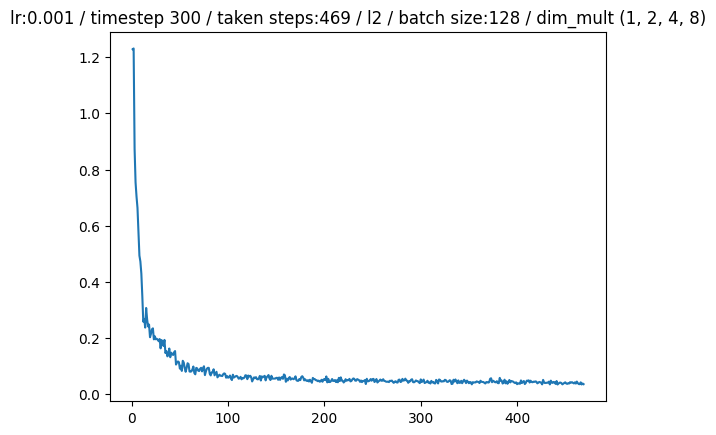

In [11]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [12]:
# save linear model
save_path = "./checkpoints/linear_net.pt"
torch.save(linear_net.state_dict(), save_path)

save_path_betas = "./checkpoints/linear_betas.pt"
torch.save({'betas':linear_betas, 
            'alphas':linear_alphas, 
            'sqrt_alphas':linear_sqrt_alphas,
            'sqrt_one_minus_alphas':linear_sqrt_one_minus_alphas,
            'sampling_1':linear_sampling_1,
            'sampling_2':linear_sampling_2}, save_path_betas)

In [13]:
# # define cosine beta schedule

# cosine_betas, cosine_alphas, cosine_sqrt_alphas, cosine_sqrt_one_minus_alphas, cosine_sampling_1, cosine_sampling_2 = total_beta_schedule(cosine_beta_schedule, timestep)

# # define cosine network and optimizer_cosine

# cosine_net = Unet(
#     dim=image_size,
#     channels=channel,
#     dim_mults=dimmults
# )
# cosine_net.to(device)

# cosine_optimizer = optim.Adam(cosine_net.parameters(), lr=lr)

In [14]:
# # train - cosine

# cosine_training_loss, cosine_training_taken_step, cosine_taken_step = training(data_loader, epochs, cosine_net, cosine_optimizer, device, 
#                                                                                cosine_sqrt_alphas, cosine_sqrt_one_minus_alphas)



In [15]:
# # plot loss - cosine

# x = np.array(cosine_training_taken_step)
# y = np.array([x.cpu().detach().numpy() for x in cosine_training_loss])

# plt.plot(x, y)
# plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{cosine_taken_step} / l1_smooth / batch size:{batchsize} / dim_mult {dimmults}")
# plt.show()

In [16]:
# # define exp beta schedule

# exp_betas, exp_alphas, exp_sqrt_alphas, exp_sqrt_one_minus_alphas, exp_sampling_1, exp_sampling_2 = total_beta_schedule(exp_beta_schedule, timestep)

# # define cosine network and optimizer_cosine

# exp_net = Unet(
#     dim=image_size,
#     channels=channel,
#     dim_mults=dimmults
# )
# exp_net.to(device)

# exp_optimizer = optim.Adam(exp_net.parameters(), lr=lr)



In [17]:
# # train - exp

# exp_training_loss, exp_training_taken_step, exp_taken_step = training(data_loader, epochs, exp_net, exp_optimizer, device, 
#                                                                                exp_sqrt_alphas, exp_sqrt_one_minus_alphas)

In [18]:
# # plot loss - exp

# x = np.array(exp_training_taken_step)
# y = np.array([x.cpu().detach().numpy() for x in exp_training_loss])

# plt.plot(x, y)
# plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{exp_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
# plt.show()

Sampling algorithm

![](./img/algo_20_2.png)

In [19]:
# sampling from net

@torch.no_grad()
def sample(x, t, betas, sampling_1, sampling_2, net, device):
    # evaluate network output
    net_t = torch.tensor([t], device=device)

    sampling_1_t = extract(sampling_1, net_t , x.shape)
    sampling_2_t = extract(sampling_2, net_t, x.shape)
    betas_t = extract(betas, net_t, x.shape)

    mu = sampling_1_t * (x - sampling_2_t * net(x, net_t))
    epsilon = torch.randn_like(x).to(device)
    x = mu + torch.sqrt(betas_t) * epsilon


    return x


@torch.no_grad()
def sampling(betas, sampling_1, sampling_2, net, device):
    z_T = torch.randn((1,1,32,32)) # sample from final latent space
    x = z_T.to(device)
    # sampling_1 = sampling_1.to(device)
    # sampling_2 = sampling_2.to(device)
    # betas = betas.to(device)

    for t in reversed(range(1, timestep)):
        x = sample(x, t, betas, sampling_1, sampling_2, net, device)

    last_t = torch.tensor([0], device=device)

    sampling_1_0 = extract(sampling_1, last_t, x.shape)
    sampling_2_0 = extract(sampling_2, last_t, x.shape)

    x = sampling_1_0 * (x - sampling_2_0 * net(x, last_t))

    return x

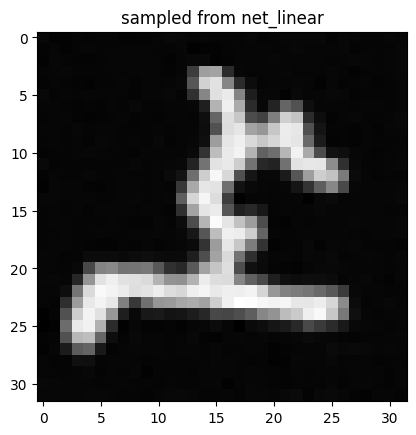

In [20]:
# plot sampled image - linear

res:torch.Tensor = sampling(linear_betas, linear_sampling_1, linear_sampling_2, linear_net, device)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

In [21]:
# # plot sampled image - cosine

# x:torch.Tensor = sampling(cosine_betas, cosine_sampling_1, cosine_sampling_2, cosine_net, device)

# plt.figure()
# plt.title("sampled from net_linear")
# plt.imshow(x.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

In [22]:
# # plot sampled image - exp

# res:torch.Tensor = sampling(exp_betas, exp_sampling_1, exp_sampling_2, exp_net, device)

# plt.figure()
# plt.title("sampled from net_linear")
# plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

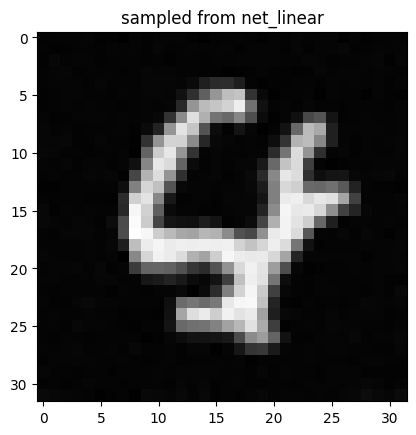

In [23]:
# test for load linear checkpoint and sample from it
loaded_linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
loaded_linear_net.load_state_dict(torch.load(save_path))
loaded_linear_net.eval()
loaded_linear_net.to(device)

loaded_linear_schedule = torch.load(save_path_betas)
loaded_linear_betas = loaded_linear_schedule['betas']
loaded_linear_alphas = loaded_linear_schedule['alphas']
loaded_linear_sqrt_alphas = loaded_linear_schedule['sqrt_alphas']
loaded_linear_sqrt_one_minus_alphas = loaded_linear_schedule['sqrt_one_minus_alphas']
loaded_linear_sampling_1 = loaded_linear_schedule['sampling_1']
loaded_linear_sampling_2 = loaded_linear_schedule['sampling_2']

res:torch.Tensor = sampling(loaded_linear_betas, loaded_linear_sampling_1, loaded_linear_sampling_2, loaded_linear_net, device)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')